This notebook simulates a gradient descent based optimization algorithm for the shape of the optical pulse at the output of a fiber optical amplifier.

The fiber amplifier in this simulation is based on an Erbium-doped active fiber.

### Imports

In [1]:
from sharq.pulsed_erbium_amplifier.pedfa import pEDFA, load_erbium_xsections
from matplotlib import pyplot
from Iaji.SignalProcessing.Signals1D.pulses import Pulse
import numpy, scipy, sympy
from Iaji.SignalProcessing.Signals1D.correlator import correlator

### Notebook Options

In [2]:
%gui qt
%matplotlib widget

### Plotting Settings

In [3]:
axis_font = {"family": "Times New Roman", "size": 15}
title_font = {"family": "Times New Roman", "size": 20}
legend_font = {"family": "Times New Roman", "size": 13}

fonts = {"axis": axis_font, "title": title_font, "legend": legend_font}

### Useful Functions

In [4]:
def get_peak(x, y, relative_threshold:float=1e-5):
    sampling_period = x[1] - x[0]
    gradient = numpy.gradient(y)
    ##Detect peaks in the gradient
    ##--
    peak_indices = scipy.signal.find_peaks(numpy.abs(gradient), threshold=relative_threshold*numpy.min(numpy.abs(gradient)))[0]
    x = x[peak_indices[0]:peak_indices[-1]]
    y = y[peak_indices[0]:peak_indices[-1]]
    peak_x = numpy.array(peak_indices)*sampling_period
    return x, y, peak_x

In [5]:
#linear interpolation between the bottom of the pulse and the initial and final values of the peak.
def zero_pad_extend(x, y, x_extend, y_extend):
    sampling_period = x[1] - x[0]
    n_extend_2 = int(numpy.ceil(x_extend/2/sampling_period))
    x = numpy.concatenate((x[0] - numpy.flipud(numpy.arange(1, n_extend_2+1))*sampling_period, x, x[-1] + numpy.arange(1, n_extend_2+1)*sampling_period))
    y = numpy.concatenate((y_extend*numpy.ones((n_extend_2, )), y, y_extend*numpy.ones((n_extend_2, ))))
    return x, y

# Time Domain Parameters

In [6]:
dt = numpy.random.choice(numpy.linspace(0.1, 0.5, 100))*1e-9 #minimum time interval, to model "almost" continuous time [s]
print("Minimum time interval: %.2f ns"%(dt*1e9))
ts = 1e-9 #maximum sampling period of the experimental instruments (acquisition systems and signal generators)

Minimum time interval: 0.33 ns


# Representation of a Typical Pulse as a Polynomial

We seek to represent a pre-shaped pulse in the basis

\begin{equation}
    \mathcal{M} := \{t^n\}_{n=0}^{N-1} \qquad n \in \mathbb{N}, N \in \mathbb{N}_+, t \in \mathbb{R}
\end{equation}

where $n$ is the monomial order and $t$ represents time.

More directly, an arbitrary pulse $p(t)$ should be accurately represented as a polynomial,

\begin{equation}
    p(t) \simeq p_\mathcal{M}(t) := \sum\limits_{n=0}^{N-1} a_n t^n  \qquad a_n \in \mathbb{R}
\end{equation}

We wish to use the  minimum value of $N$ such that $p_\mathcal{M}(t)$ is ''close enough'' to $p(t)$ is some (functional) sense, for every pulse $p(t)$.

In [7]:
def pulse2polynomial(pulse:Pulse, order, sampling_period, only_peak=True):
    duration = pulse.stop-pulse.start
    time_extend = duration*0.2
    time, pulse_sampled = pulse.sample(x1=pulse.start-time_extend/2, x2=pulse.stop+time_extend/2, fs=1/sampling_period)
    pulse_minimum = numpy.min(pulse_sampled)
    if only_peak:
        time, pulse_sampled, _ = get_peak(time, pulse_sampled)   
    poly_fit = numpy.polyfit(time, pulse_sampled, order-1)
    p_P = numpy.poly1d(poly_fit)
    return *zero_pad_extend(time, p_P(time), x_extend=(pulse.stop - pulse.start)*0.2, y_extend=pulse_minimum), p_P

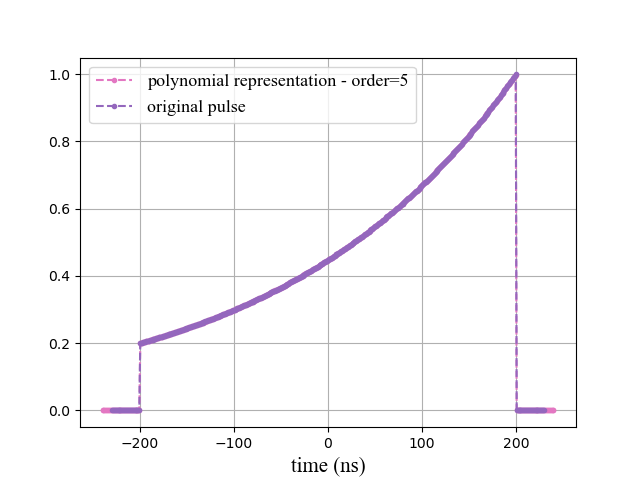

In [8]:
#Test for pulse2polynomial
p = Pulse()
p.symbolic.numeric_evaluation_module = "sympy"
p.set_shape_standard(start=-200e-9, stop=200e-9, window_type="rect", peak_type="exp",\
                     rise=20e-9, fall=40e-9, initial_level=0.2, final_level=1)
ts = 1e-9 #acquisition system's sampling period [s]
fs = numpy.ceil(1/ts*1e-9)*1e9
t_start, t_stop = (-230e-9, 230e-9)
fig = pyplot.figure()
axis = fig.add_subplot(111)
time, p_sampled = p.sample(t_start, t_stop, fs=fs)
poly_order = 5
time_poly, p_poly, polynomial = pulse2polynomial(p, order=5, sampling_period=ts)
axis.plot(time_poly*1e9, p_poly, linestyle="--", marker=".", color="tab:pink", label="polynomial representation - order=%d"%poly_order)
axis.plot(time*1e9, p_sampled, linestyle="--", marker=".", color="tab:purple", label="original pulse")
axis.set_xlabel("time (ns)", font=fonts["axis"])
axis.grid()
axis.legend(prop=fonts["legend"])

# Measures of Closeness Between Pulses

We need a (Lebesgue) measure to assess the quality of the pulse optimization procedure.

## $\mathcal{L}_2(\mathbb{R})$ Square-Distance

A natural measure of closeness between two square-integrable functions, such as the desired pulse $p_d(t)$ and the pulse measured at the output of the fiber amplified, say $p(t)$, is

\begin{equation}
    \left|\left|p_d(t) - p(t)\right|\right|^2_{\mathcal{L}_2(\mathbb{R})} := \int\limits_{\mathbb{R}} \left|p_d(t) - p(t)\right|^2 dt \simeq \int\limits_{\mathcal{D}_{max}} \left|p_d(t) - p(t)\right|^2 dt
\end{equation}

where $\mathcal{D}_{max}$ is the interval of maximum duration among the two pulses.

In [9]:
def L2_distance(f1, f2, dx=1):
    return numpy.trapz(numpy.abs(f2-f1)**2, dx=dx)

In [10]:
#Test for L2_distance
x = numpy.linspace(0, 1, 100)
f1, f2 = (numpy.sin(x*numpy.pi), numpy.sin(x*numpy.pi))
L2_distance(f1, f2, x[1]-x[0])

# Defining the Initial Input Fields

## Pump Field

In [11]:
input_pump_power = 5 #[W]

## Signal Field

In [12]:
input_peak_power = 300e-3 #[W]

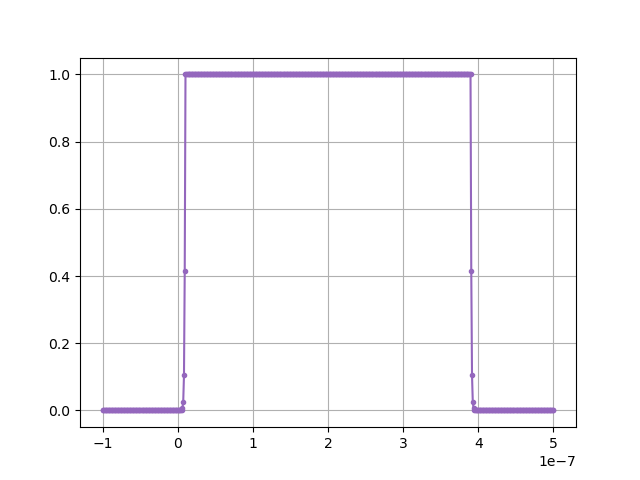

In [13]:
# Initial pulse shape
input_start = 0 #pulse start time [s]
input_stop = 400e-9 #pulse stop time [s]
input_rise = 10e-9
input_fall = input_rise

input_pulse = Pulse()
input_pulse.symbolic.numeric_evaluation_module = "sympy"
input_pulse.set_shape_standard(start=input_start, stop=input_stop, window_type="exp", peak_type="exp",\
                     rise=input_rise, fall=input_fall, initial_level=1, final_level=1)
axis_input_pulse = input_pulse.plot(input_start-100e-9, input_stop+100e-9, fs=1/ts)

# Defining the Measurement System

The photodetection system takes the output signal field pulse from the optical amplifier $p(t)$ and outputs a voltage of the type

\begin{equation}
    p(t) \longrightarrow A_{det} p(t+T_{det}) + B_{det} + n_{det}(t) 
\end{equation}

where $T_{det} \in \mathbb{R}_{o+}$ [s] is the time delay between the optical input and the output of the measurement system, $A_{det} \in \mathbb{R}$ [V/W] is a scale factor, $B_{det} \in \mathbb{R}$ [V] is the measurement offset and 

\begin{equation}
    n_{det}(t) \sim \mathcal{N}\left(0, \sigma^2_{det}\right)
\end{equation}

is the electronic noise of the measurement system, with zero mean and variance $\sigma^2_{det} \in \mathbb{R}_+$ [V].

To model jitter in the measurement time, we consider $T_{det}$ to have uniform probability distribution between 0 and a maximum delay $T_{det, max}$:

\begin{equation}
    T_{det} \sim \mathcal{U}\left(\left[-\frac{T_{det, max}}{2}, \frac{T_{det, max}}{2}\right]\right)
\end{equation}

In [14]:
def delay(x:numpy.ndarray, y:numpy.ndarray, x_delay:float):
    assert x.shape == y.shape
    dt = x[1] - x[0]
    x_new = x+x_delay
    indices = numpy.where(numpy.logical_and(x>=x_new[0], x<=x_new[-1]))
    y_new = y[indices]
    if x_delay < 0:
        x_new = x_new[0:y_new.size]
    else:
        x_new = x_new[int(numpy.ceil(x_delay/dt)):]
    return x_new, y_new
#-----------
class DetectionSystem:
    #--------------
    def __init__(self, A_det:float=1, B_det:float=0, sigma_det:float=0, T_det_max:float=0):
        self.A_det = A_det
        self.B_det = B_det
        self.sigma_det = sigma_det
        self.T_det_max = T_det_max
    #--------------
    def measure(self, input_time:numpy.ndarray, input_power:numpy.ndarray, ts:float):
        dt = input_time[1]-input_time[0]
        if dt >= ts:
            assert numpy.isclose(dt, ts)
            n_sampling = 1
        else:
            assert dt < ts
            n_sampling = int(ts/dt)
        #Sample the input signal
        time = input_time[::n_sampling]
        power = input_power[::n_sampling]
        #Randomly delay
        self.T_det = numpy.random.choice(numpy.linspace(-self.T_det_max/2, self.T_det_max/2, int(self.T_det_max/ts)))
        time, power = delay(time, power, self.T_det)
        #Apply Gaussian electronic noise
        n_det = numpy.random.normal(0, self.sigma_det, time.shape)
        return time, self.A_det*power + self.B_det + n_det

Detection delay: 33.7 ns


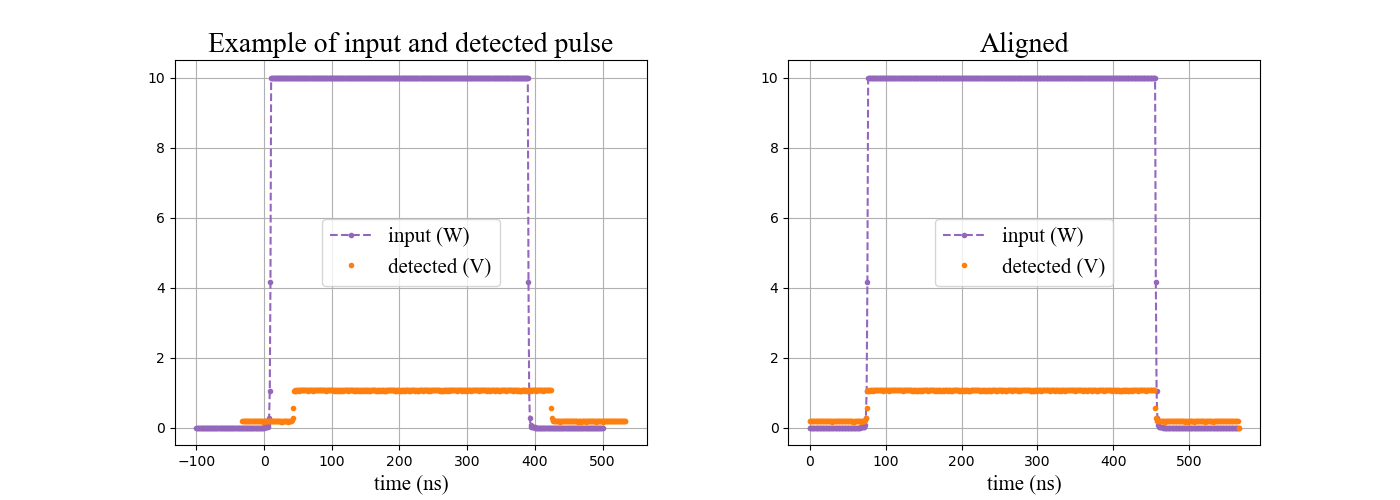

In [15]:
#Test for DetectionSystem
max_peak_power = 100 #[W]
B_det = 180e-3 #detector offset [V]
A_det = (9-B_det)/100

T_det_max = 100e-9 #maximum time delay of the measurement system [s]
sigma_det = 5e-3 #electronic noise standard deviation [V]

det = DetectionSystem(A_det, B_det, sigma_det, T_det_max)
#Create input pulse and detect
input_time, input_pulse_array = input_pulse.sample(x1=-100e-9, x2=500e-9, fs=fs)
input_pulse_array *= 10
time_det, pulse_det = det.measure(input_time, input_pulse_array, ts=ts)
#Align the input and detected pulses in time
corr = correlator(signal_1=input_pulse_array, signal_2=pulse_det, sampling_period=ts)
input_pulse_array_corr, pulse_det_corr, time_corr = corr.recorrelate()
#Plot
fig = pyplot.figure(figsize=(14, 5))
fig.subplots_adjust(wspace=0.3)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Example of input and detected pulse", font=fonts["title"])
ax.set_xlabel("time (ns)", font=fonts["axis"])
ax.plot(input_time*1e9, input_pulse_array, linestyle="--", marker=".", color="tab:purple", label="input (W)")
ax.plot(time_det*1e9, pulse_det, linestyle="None", marker=".", color="tab:orange", label="detected (V)")
print("Detection delay: %.1f ns"%(det.T_det*1e9))
ax.grid()
ax.legend(prop=fonts["axis"])
##Recorrelated axis
ax_corr = fig.add_subplot(1, 2, 2)
ax_corr.set_title("Aligned", font=fonts["title"])
ax_corr.set_xlabel("time (ns)", font=fonts["axis"])
ax_corr.plot(time_corr*1e9, input_pulse_array_corr, linestyle="--", marker=".", color="tab:purple", label="input (W)")
ax_corr.plot(time_corr*1e9, pulse_det_corr, linestyle="None", marker=".", color="tab:orange", label="detected (V)")
ax_corr.grid()
ax_corr.legend(prop=fonts["axis"])

# Defining the Fiber Optical Amplifier

## The Absorption and Emission Cross-sections of the Active Fiber

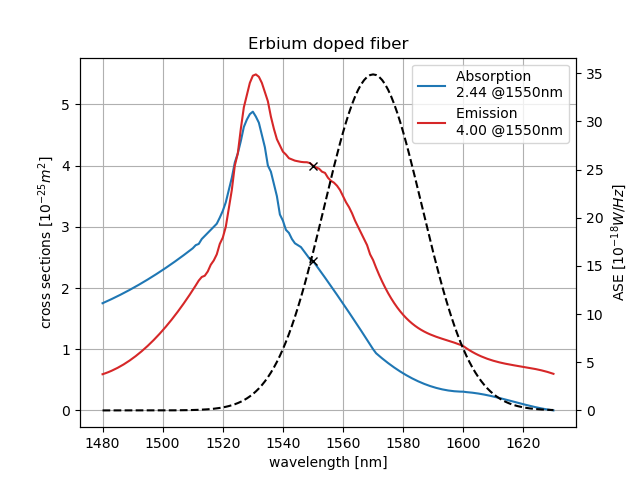

In [16]:
#Define the signal wavelength
lam_sig = 1550e-9
#Get examples of the wavelength-dependent absorption and emission cross-sections from experimental data
xsections_vals, xsections_specs = load_erbium_xsections(lam_sig)
wl = xsections_specs[0]
xabs = xsections_specs[1]
xemi = xsections_specs[2]
fig, ax = pyplot.subplots()
ax.plot(wl*1e9,xabs*1e25, 'C0', label = f'Absorption \n{xsections_vals[0]*1e25:.2f} @1550nm')
ax.plot(wl*1e9,xemi*1e25, 'C3', label = f'Emission \n{xsections_vals[1]*1e25:.2f} @1550nm')
ax.plot(lam_sig*1e9, xsections_vals[0]*1e25, 'kx')
ax.plot(lam_sig*1e9, xsections_vals[1]*1e25, 'kx')
axt = pyplot.twinx(ax)
axt.plot(wl*1e9, xsections_specs[3]*1e18, 'k--')
ax.set_title('Erbium doped fiber')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel(r'cross sections [$10^{-25} m^2$]')
ax.legend(loc=1)
axt.set_ylabel('ASE [$10^{-18} W/Hz$]')
ax.grid()

In [17]:
pedfa = pEDFA(sig_input=input_peak_power, pump_input=input_pump_power)
pedfa.set_xsection_vals(*xsections_vals)
pedfa.set_xsection_specs(*xsections_specs)
pedfa.define_fiber(L=0.25, R=3e-6, rho=6e25, N_fiber=200, N_padding=20)
pedfa.set_ASE(ASE=False)
pedfa.precalc(wait=1e-4, N=20)

In [18]:
pulse_time, input_pulse_array = input_pulse.sample(fs=1/dt)
pedfa.define_pulse(input_pulse_array*input_peak_power, dt)
pedfa.define_pump(pump_array=[])
pedfa.run_pulse()

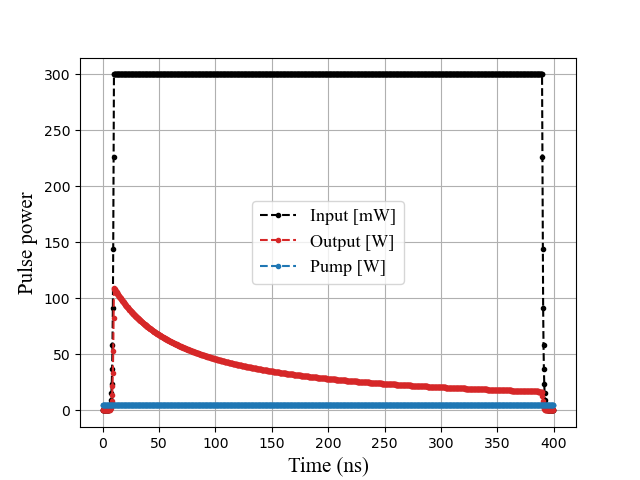

In [19]:
fig, ax = pyplot.subplots()
ax.plot(pedfa.pulse_time*1e9, pedfa.inputpulse*1e3, 'k', linestyle="--", marker=".", label='Input [mW]')
ax.plot(pedfa.pulse_time*1e9, pedfa.outputpulse, 'C3', linestyle="--", marker=".",label='Output [W]')
ax.plot(pedfa.pulse_time*1e9, pedfa.inputpump, 'C0', linestyle="--", marker=".",label='Pump [W]')
ax.set_xlabel('Time (ns)', font=fonts["axis"])
ax.set_ylabel('Pulse power', font=fonts["axis"], color='k')
ax.legend(prop=fonts["legend"])
ax.grid()

# Gradient Descent Optimization of the Input Pulse Shape


We assume the input pulse to be described as a polynomial of chosen degree N, meaning that an input pulse $p_{in}(t)$ is described as 

\begin{equation}
    p_{in}(t) = \sum\limits_{n=0}^{N-1} a_n t^n  \qquad a_n \in \mathbb{R}
\end{equation}

Our aim is to optimize the shape of $p_{in}(t)$ to make the pulse at the amplifier output as close as possible to a target pulse $p^*(t)$.

The coefficient vector $\vec{a} := \left(a_0, ..., a_{N-1}\right) \in \mathbb{R}^N$ is the one that needs to be optimized.

We start from an initial guess $\vec{a}^{(0)} = \left(a^{(0)}_0, ..., a^{(0)}_N\right)$. At any given iteration $k\in \mathbb{N}$ of the algorithm, the following happens:

1. Given the coefficient vector $\vec{a}^{(k)}$, the pulse $p^{(k)}_{in}(t) = \sum\limits_{n=0}^{N-1} a^{(k)}_n t^n$ is input to the amplifier
2. The pulse output from the amplifier, $p^{(k)}_{out}(t)$, is measured via the photodetection system, yielding the voltage pulse $p^{(k)}_{out, det}(t)$
3. $p^{(k)}_{out, det}(t)$ is digitally normalized and aligned with $p^*(t)$ in time 
4. The cost function (e.g., the $\mathcal{L}_2(\mathbb{R})$ square-distance) is determined from $p^*(t)$ and $p^{(k)}_{out, det}(t)$, yelding $c^{(k)} = c\left(\vec{a}^{(k)}\right)$
5. The gradient of the cost function $c$ around the point $\vec{a}^{(k)}$ is determined, by translating each component of $\vec{a}^{(k)}$ by a step $\delta a$ in both positive and negative directions, and repeating steps 1-4 for each correspondingly generated pulse, to form the gradient $\vec{\nabla}\left(c^{(k)}\right)$
6. The next coefficient vector is chosen as $\vec{a}^{(k+1)} = \vec{a}^{(k)} - \eta \vec{\nabla}\left(c^{(k)}\right)$, where $\eta$ is the convergence rate

## Gradient Approximation by Finite Differences

### First-order Finite Differences

Given a sequence $c(\vec{a})$ and a minimum step $\delta a$, the gradient of $c$ at the point $\vec{a}$ can be approximated by

\begin{equation}
    \vec{\nabla}\left(c(\vec{a})\right) \simeq \frac{1}{2\delta a}\left(\left(\Delta c\right)_0, ..., \left(\Delta c\right)_{N-1}\right)
\end{equation}

where 

\begin{equation}
    \left(\Delta c\right)_n := c\left(\vec{a}+\delta a \vec{e}_n\right) - c\left(\vec{a}-\delta a \vec{e}_n\right)
\end{equation}

and $\vec{e}_n := (0_{0}, ..., 0_{n-1}, 1_{n}, 0_{n+1}, ..., 0_{N-1})$ is a canonical basis vector.


## Convergence Condition
The algorithm must stop once a certain condition, which should reflect the satisfactory quality of the output pulse at some iteration $k^*$, is met.

### Condition on the Value of the Cost Function
The algorithm may stop when $c^{(k^*)} < \epsilon_c$, where $\epsilon_c \in \mathbb{R}$ is chosen arbitrarily small.

### Condition on the Value of the Gradient
If the gradient of $c$ around the point $\vec{a}^{(k^*)}$ is lower than a certain value $\epsilon_\nabla$, i.e., $||\vec{\nabla}\left(c^{(k^*)}\right)|| < \epsilon_\nabla$, the algorithm is not progressing any significantly further, and the algorithm may stop.


## Defining the Target Output Pulse

No handles with labels found to put in legend.


Detection delay: 33.7 ns


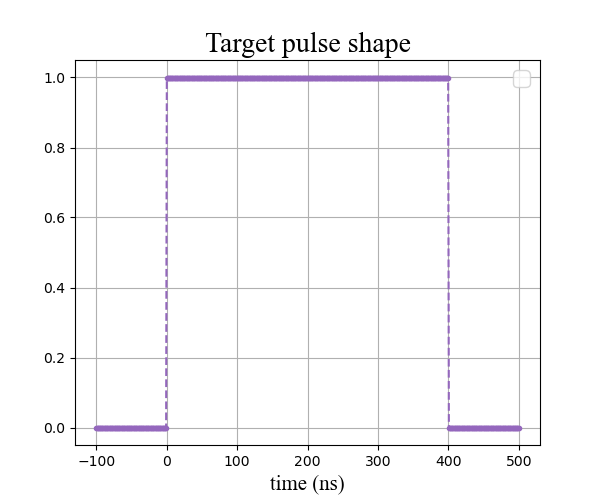

In [20]:
#Define the target output pulse
target_pulse = Pulse()
target_start = 0 #pulse start time [s]
target_stop = 400e-9 #pulse stop time [s]
##Define and sample pulse
target_pulse = Pulse()
target_pulse.symbolic.numeric_evaluation_module = "sympy"
target_pulse.set_shape_standard(start=target_start, stop=target_stop, window_type="rect", peak_type="flat")
target_time, p_target = target_pulse.sample(x1=target_start-100e-9, x2=target_stop+100e-9, fs=fs)
##Plot pulse
fig = pyplot.figure(figsize=(6, 5))
ax_target = fig.add_subplot(111)
ax_target.set_title("Target pulse shape", font=fonts["title"])
ax_target.set_xlabel("time (ns)", font=fonts["axis"])
ax_target.plot(target_time*1e9, p_target, linestyle="--", marker=".", color="tab:purple")
print("Detection delay: %.1f ns"%(det.T_det*1e9))
ax_target.grid()
ax_target.legend(prop=fonts["axis"])

In [25]:
from scipy.signal import resample

def _run_pulse(amplifier:pEDFA, dt:float, input_pulse_array:numpy.ndarray, input_peak_power:float):
    amplifier.define_pulse(input_pulse_array*input_peak_power, dt)
    amplifier.define_pump(pump_array=[])
    amplifier.run_pulse()
    return zero_pad_extend(amplifier.pulse_time, amplifier.outputpulse, x_extend=100e-9, y_extend=numpy.min(amplifier.outputpulse))

def _measure_and_compute_cost(time:numpy.ndarray, p_out:numpy.ndarray, p_target:numpy.ndarray, ts:float):
    #Detect the pulse
    time_det, p_out_det = det.measure(time, p_out, ts)
    #pyplot.plot(time*1e9, p_out, linestyle="--", marker=".", color="tab:green")
    #pyplot.plot(time_det*1e9, p_out_det, linestyle="--", marker=".", color="tab:purple")
    #Normalize the detected pulse
    p_out_det -= numpy.min(p_out_det)
    p_out_det /= numpy.max(p_out_det)
    #Align the detected pulse with the target pulse in time
    corr = correlator(p_target.copy(), p_out_det.copy(), ts)
    p_target_corr, p_out_det_corr, time_det_corr = corr.recorrelate()
    p_out_det_corr *= -1
    #p_target_corr, p_out_det_corr, time_det_corr = (corr.signal_1, corr.signal_2, numpy.linspace(0, (corr.n_samples-1)*corr.Xs, corr.n_samples))
    #Compute the cost
    cost = L2_distance(p_target_corr, p_out_det_corr)
    return cost, time_det_corr, p_out_det_corr, p_target_corr

Remaining iterations: 5
Remaining iterations: 4
Remaining iterations: 3
Remaining iterations: 2
Remaining iterations: 1


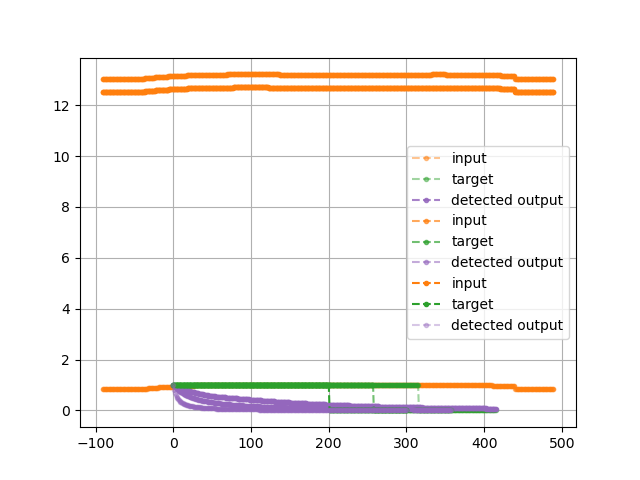

In [31]:
# Test example of gradient descent
#da = 0.01 #minimum step for the coefficient vector component
eta = 0.001 #convergence rate
N = 5 #order of the polynomial, equal to the dimension of the coefficient vector
input_time_base, p_in, input_polynomial = pulse2polynomial(pulse=target_pulse, order=N, only_peak=True, sampling_period=ts) #Initialize the initial pulse as the target pulse
a = input_polynomial.coefficients
cost = []
k_max = 5
#Prepare figures for monitoring
pyplot.figure()
for k in range(k_max):
    print("Remaining iterations: %d"%(k_max-k))
    #Prepare input pulse
    p_in = numpy.poly1d(a)(input_time_base)
    input_time, p_in = zero_pad_extend(input_time_base, p_in ,x_extend=100e-9, y_extend=numpy.min(p_in))
    #Run the pulse thorugh the amplifier
    output_time, p_out = _run_pulse(pedfa, ts, p_in, input_peak_power)
    #pyplot.plot(output_time*1e9, p_out)
    c, time_det_corr, p_out_det_corr, p_target_corr = _measure_and_compute_cost(output_time, p_out, p_target, ts)
    if k%2 == 0:
        pyplot.plot(input_time*1e9, p_in, linestyle="--", marker=".", color="tab:orange", alpha=numpy.exp(-(k_max-(k+1))/k_max), label="input")
        pyplot.plot(time_det_corr*1e9, p_target_corr, linestyle="--", marker=".", color="tab:green", alpha=numpy.exp(-(k_max-(k+1))/k_max), label="target")
        pyplot.plot(time_det_corr*1e9, p_out_det_corr, linestyle="--", marker=".", color="tab:purple", alpha=numpy.exp(-(k+1)/k_max), label="detected output")
    cost.append(c)
    #Compute the gradient
    grad_c = numpy.zeros((N,))
    for n in range(N):
        da = abs(a[n])/1000
        a_plus, a_minus = (a.copy(), a.copy())
        
        a_plus[n] += da
        p_in_plus = numpy.poly1d(a_plus)(input_time_base)
        input_time, p_in_plus = zero_pad_extend(input_time_base, p_in_plus ,x_extend=100e-9, y_extend=numpy.min(p_in_plus))
        output_time, p_out = _run_pulse(pedfa, ts, p_in_plus, input_peak_power)
        c_plus, _, _, _ = _measure_and_compute_cost(output_time, p_out, p_target, ts)
        
        a_minus[n] -= da
        p_in_minus = numpy.poly1d(a_minus)(input_time_base)
        input_time, p_in_minus = zero_pad_extend(input_time_base, p_in_minus ,x_extend=100e-9, y_extend=numpy.min(p_in_minus))
        output_time, p_out = _run_pulse(pedfa, ts, p_in_minus, input_peak_power)
        c_minus, _, _, _ = _measure_and_compute_cost(output_time, p_out, p_target, ts)
        grad_c[n] = (c_plus - c_minus)/(2*da)
    a -= eta*grad_c
pyplot.legend()
pyplot.grid()

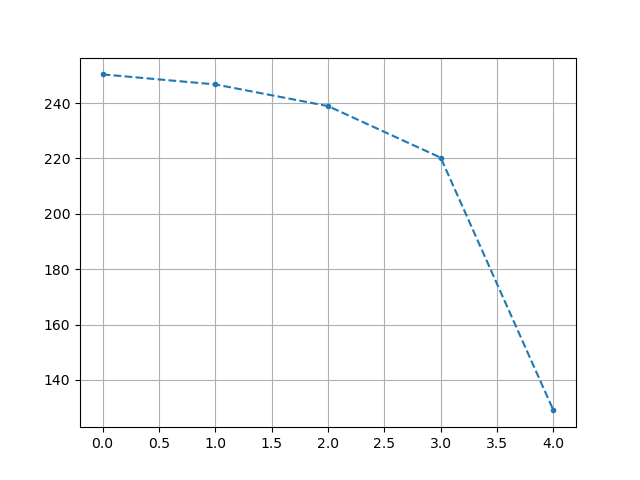

In [23]:
pyplot.figure()
pyplot.plot(cost, linestyle="--", marker=".")
pyplot.grid()

In [24]:
print(cost)

[250.37260234984691, 246.76071356170075, 238.92422684650026, 220.27881434544898, 128.9934559320618]
